In [1]:
"""
Notebook: Classificação de Espécies de Plantas a partir de Imagens de Folhas

Fases:``
  1) Carregamento e segmentação das folhas
  2) Extração de descritores geométricos
  3) Redução de dimensionalidade com PCA
  4) Classificação (kNN e SVM)
  5) Avaliação (matriz de confusão, métricas, análise de erros)

Requisitos:
  - Pasta 'Leaves/' na raiz deste projeto, contendo as imagens (.jpg / .png)
  - Nomes de arquivos com prefixo numérico representando a classe, por exemplo:
        1001_1.jpg, 1001_2.jpg, 1002_1.png, ...
"""

print("Notebook de classificação de folhas inicializado.")

Notebook de classificação de folhas inicializado.


In [2]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import pandas as pd
import seaborn as sns
from collections import Counter

# Configurações gráficas
plt.style.use("seaborn-v0_8")
sns.set()
%matplotlib inline

print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


In [54]:
# Caminho da pasta com as imagens
caminho_dataset = "Leaves"  # ajuste se necessário

print(f"Pasta do dataset configurada como: {caminho_dataset}")
print("Certifique-se de que esta pasta existe e contém as imagens de folhas.")

Pasta do dataset configurada como: Leaves
Certifique-se de que esta pasta existe e contém as imagens de folhas.


In [55]:
def carregar_imagens(caminho_dataset):
    """
    Carrega todas as imagens .jpg e .png de uma pasta.

    Retorna:
        - imagens: lista de arrays (BGR, OpenCV)
        - nomes: lista de nomes de arquivos
    """
    extensoes = ('*.jpg', '*.png')
    caminhos = []
    for ext in extensoes:
        caminhos.extend(glob(os.path.join(caminho_dataset, ext)))
    
    imagens = []
    nomes = []

    for caminho in caminhos:
        img = cv2.imread(caminho)
        if img is not None:
            imagens.append(img)
            nomes.append(os.path.basename(caminho))
        else:
            print(f"Aviso: não foi possível carregar a imagem: {caminho}")
    
    print(f"Total de imagens carregadas: {len(imagens)}")
    return imagens, nomes


def segmentar_folha(imagem):
    """
    Segmenta a folha do fundo usando:
      - Conversão para cinza
      - Limiarização de Otsu
      - Operações morfológicas (fechamento + abertura)
      - Seleção do maior contorno

    Retorna:
        - mascara (imagem binária, uint8, 0 e 255)
    """
    cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    
    # Limiarização de Otsu
    _, limiar = cv2.threshold(cinza, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Garante que a folha esteja em branco (255) e o fundo em preto (0)
    if np.sum(limiar == 255) > np.sum(limiar == 0):
        limiar = cv2.bitwise_not(limiar)

    # Operações morfológicas para limpar ruídos
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    limpo = cv2.morphologyEx(limiar, cv2.MORPH_CLOSE, kernel)
    limpo = cv2.morphologyEx(limpo, cv2.MORPH_OPEN, kernel)

    # Encontrar contornos externos
    contornos, _ = cv2.findContours(limpo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contornos:
        # Caso extremo: não encontrou contorno
        return np.zeros_like(cinza)
        
    # Seleciona o maior contorno (assumimos ser a folha)
    maior_contorno = max(contornos, key=cv2.contourArea)
    mascara = np.zeros_like(limpo)
    cv2.drawContours(mascara, [maior_contorno], -1, 255, thickness=cv2.FILLED)
    
    return mascara

print("Funções de carregamento e segmentação definidas.")

Funções de carregamento e segmentação definidas.


Total de imagens carregadas: 1907
Exemplo de segmentação em até 3 imagens:


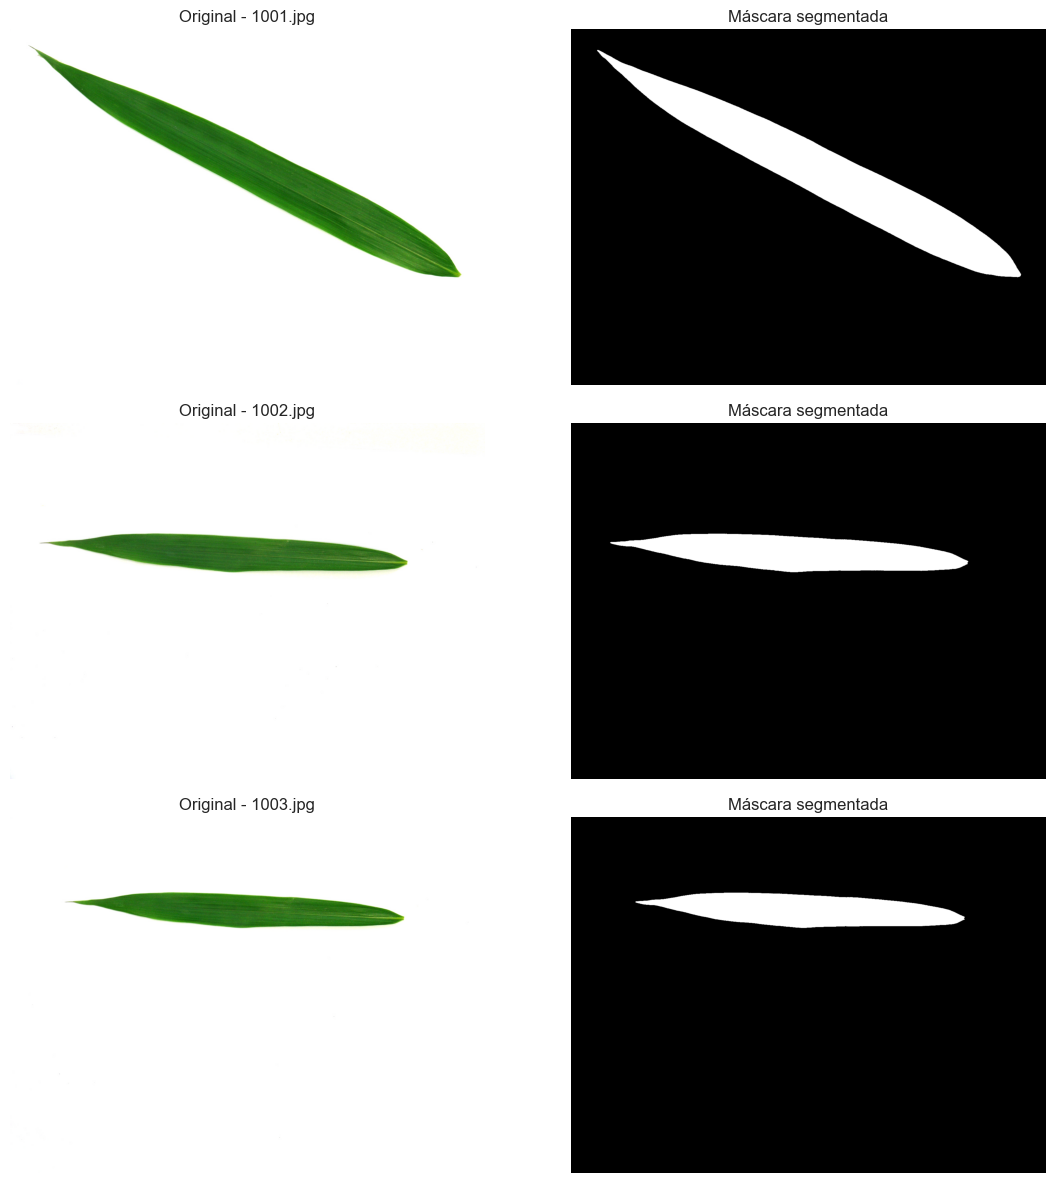

In [56]:
imagens, nomes = carregar_imagens(caminho_dataset)

if len(imagens) == 0:
    print("Nenhuma imagem encontrada na pasta 'Leaves'. Verifique o caminho e o conteúdo da pasta.")
else:
    print("Exemplo de segmentação em até 3 imagens:")

    num_exemplos = min(3, len(imagens))
    plt.figure(figsize=(12, 4 * num_exemplos))

    for i in range(num_exemplos):
        img_bgr = imagens[i]
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        mascara = segmentar_folha(img_bgr)

        # Imagem original
        plt.subplot(num_exemplos, 2, 2*i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Original - {nomes[i]}")
        plt.axis("off")

        # Máscara
        plt.subplot(num_exemplos, 2, 2*i + 2)
        plt.imshow(mascara, cmap="gray")
        plt.title("Máscara segmentada")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [57]:
def calcular_descritores(mascara):
    """
    Calcula descritores geométricos a partir da máscara da folha:
      - circularidade
      - excentricidade
      - número de cantos
      - razão altura/largura

    Retorna:
        dicionário com os quatro descritores.
    """
    # Encontrar contorno principal
    contornos, _ = cv2.findContours(mascara, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contornos:
        # Máscara vazia ou sem contornos
        return {
            'circularidade': 0.0,
            'excentricidade': 0.0,
            'num_cantos': 0,
            'razao_hw': 0.0
        }

    maior_contorno = max(contornos, key=cv2.contourArea)

    # Área e perímetro
    area = cv2.contourArea(maior_contorno)
    perimetro = cv2.arcLength(maior_contorno, True)

    # Circularidade/compacidade
    circularidade = 4 * np.pi * area / (perimetro ** 2) if perimetro != 0 else 0.0

    # Excentricidade (usando elipse ajustada)
    if len(maior_contorno) >= 5:  # fitEllipse requer >= 5 pontos
        elipse = cv2.fitEllipse(maior_contorno)
        (_, axes, _) = elipse
        maior_eixo = max(axes)
        menor_eixo = min(axes)
        excentricidade = np.sqrt(1 - (menor_eixo / maior_eixo) ** 2) if maior_eixo != 0 else 0.0
    else:
        excentricidade = 0.0

    # Número de cantos (Shi-Tomasi)
    cantos = cv2.goodFeaturesToTrack(
        mascara, maxCorners=100, qualityLevel=0.01, minDistance=10
    )
    num_cantos = 0 if cantos is None else len(cantos)

    # Razão altura/largura (bounding box)
    x, y, w, h = cv2.boundingRect(maior_contorno)
    razao_hw = h / w if w != 0 else 0.0

    return {
        'circularidade': float(circularidade),
        'excentricidade': float(excentricidade),
        'num_cantos': int(num_cantos),
        'razao_hw': float(razao_hw)
    }

print("Função de extração de descritores definida.")

Função de extração de descritores definida.


Processando imagem: 1001.jpg
  -> {'circularidade': 0.20214506092550538, 'excentricidade': 0.9954648599108114, 'num_cantos': 100, 'razao_hw': 0.5371148459383753}
Processando imagem: 1002.jpg
  -> {'circularidade': 0.1948462888527573, 'excentricidade': 0.9949232881513825, 'num_cantos': 100, 'razao_hw': 0.1077943615257048}
Processando imagem: 1003.jpg
  -> {'circularidade': 0.19685832396221356, 'excentricidade': 0.9947271692995482, 'num_cantos': 100, 'razao_hw': 0.1073038773669973}
Processando imagem: 1004.jpg
  -> {'circularidade': 0.27813958630948443, 'excentricidade': 0.9896201204720414, 'num_cantos': 100, 'razao_hw': 0.18884758364312268}
Processando imagem: 1005.jpg
  -> {'circularidade': 0.2879597051844797, 'excentricidade': 0.9853598348635729, 'num_cantos': 100, 'razao_hw': 0.20224719101123595}
Processando imagem: 1006.jpg
  -> {'circularidade': 0.21080275219707295, 'excentricidade': 0.9942464929440162, 'num_cantos': 100, 'razao_hw': 0.6657477601654032}
Processando imagem: 1007.jpg

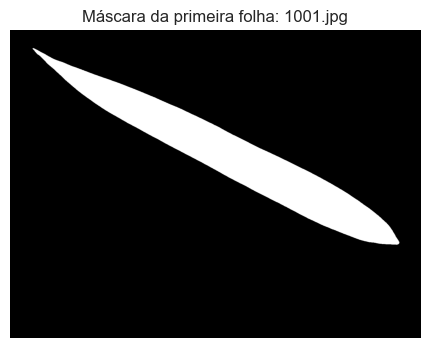

In [58]:
if len(imagens) == 0:
    print("Impossível extrair descritores: nenhuma imagem carregada.")
else:
    todos_descritores = []

    for i, imagem in enumerate(imagens):
        print(f"Processando imagem: {nomes[i]}")
        mascara = segmentar_folha(imagem)
        descritores = calcular_descritores(mascara)
        todos_descritores.append(descritores)
        print(f"  -> {descritores}")

    print("\nExtração de descritores concluída para todas as imagens.")

    # Visualizar máscara e descritores da primeira imagem
    mascara_exemplo = segmentar_folha(imagens[0])
    plt.figure(figsize=(6, 4))
    plt.imshow(mascara_exemplo, cmap='gray')
    plt.title(f'Máscara da primeira folha: {nomes[0]}')
    plt.axis("off")
    plt.show()

In [59]:
if len(imagens) > 0:
    df_descritores = pd.DataFrame(todos_descritores)
    print("DataFrame de descritores (primeiras linhas):")
    display(df_descritores.head())

    print("\nEstatísticas descritivas dos descritores:")
    display(df_descritores.describe())
else:
    df_descritores = None

DataFrame de descritores (primeiras linhas):


,circularidade,excentricidade,num_cantos,razao_hw
0,0.202145,0.995465,100,0.537115
1,0.194846,0.994923,100,0.107794
2,0.196858,0.994727,100,0.107304
3,0.278140,0.989620,100,0.188848
4,0.287960,0.985360,100,0.202247



Estatísticas descritivas dos descritores:


,circularidade,excentricidade,num_cantos,razao_hw
count,1907.000000,1907.000000,1907.000000,1907.000000
mean,0.461361,0.767959,94.493970,0.677474
std,0.193501,0.279310,22.815776,0.161321
min,0.038116,0.000000,0.000000,0.107304
25%,0.324336,0.736930,100.000000,0.604396
50%,0.470132,0.892951,100.000000,0.692833
75%,0.602435,0.947138,100.000000,0.750000
max,0.823765,0.999891,100.000000,1.221111


[Fase 3] Variância explicada por componente:
  PC1: 0.5409 (54.09%)
  PC2: 0.2573 (25.73%)
  PC3: 0.1587 (15.87%)
  PC4: 0.0431 (4.31%)

[Fase 3] Variância acumulada:
  Até PC1: 0.5409 (54.09%)
  Até PC2: 0.7982 (79.82%)
  Até PC3: 0.9569 (95.69%)
  Até PC4: 1.0000 (100.00%)

[Fase 3] PCA aplicado com 2 componentes.
  PC1: 0.5409 (54.09%)
  PC2: 0.2573 (25.73%)
  Variância total explicada: 0.7982 (79.82%)


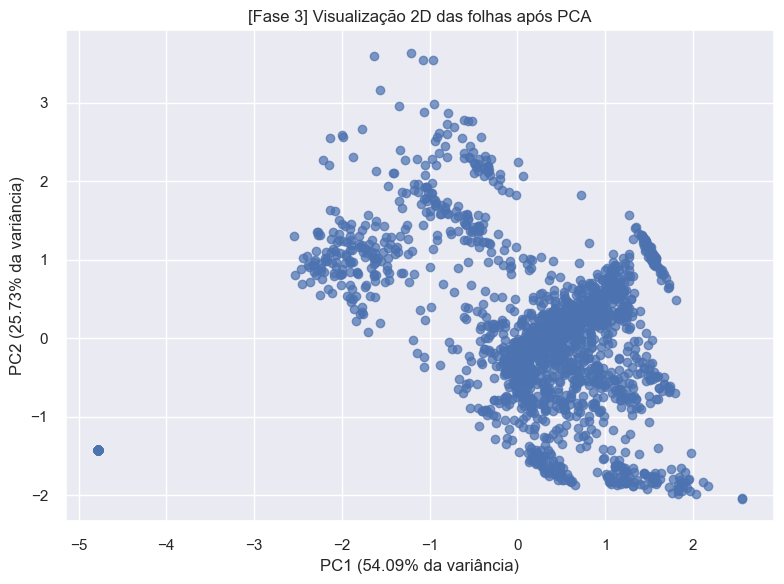

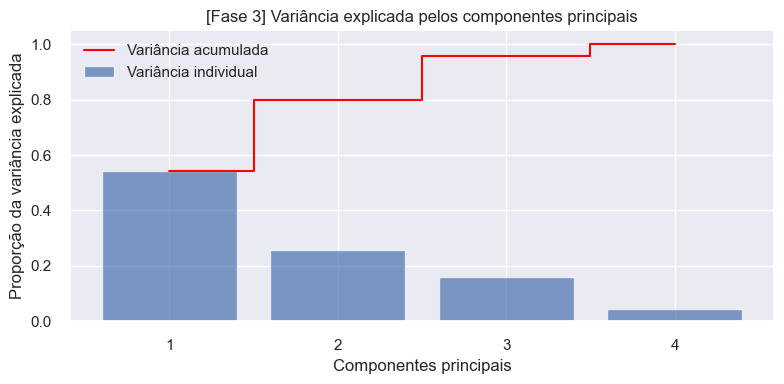

In [60]:
if df_descritores is None or df_descritores.shape[0] == 0:
    print("PCA não pode ser aplicado: DataFrame de descritores vazio.")
else:
    # Normalização
    scaler = StandardScaler()
    descritores_normalizados = scaler.fit_transform(df_descritores)

    # PCA completo para analisar variância
    pca_completo = PCA()
    pca_completo.fit(descritores_normalizados)
    variancia_explicada = pca_completo.explained_variance_ratio_
    variancia_acumulada = np.cumsum(variancia_explicada)

    print("[Fase 3] Variância explicada por componente:")
    for i, var in enumerate(variancia_explicada):
        print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

    print("\n[Fase 3] Variância acumulada:")
    for i, var_ac in enumerate(variancia_acumulada):
        print(f"  Até PC{i+1}: {var_ac:.4f} ({var_ac*100:.2f}%)")

    # Escolher 2 componentes principais
    n_componentes = 2
    pca = PCA(n_components=n_componentes)
    componentes_principais = pca.fit_transform(descritores_normalizados)

    print(f"\n[Fase 3] PCA aplicado com {n_componentes} componentes.")
    for i in range(n_componentes):
        print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} "
              f"({pca.explained_variance_ratio_[i]*100:.2f}%)")
    var_total = np.sum(pca.explained_variance_ratio_)
    print(f"  Variância total explicada: {var_total:.4f} ({var_total*100:.2f}%)")

    # Scatter 2D dos dados nas duas primeiras componentes
    plt.figure(figsize=(8, 6))
    plt.scatter(componentes_principais[:, 0],
                componentes_principais[:, 1],
                alpha=0.7)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% da variância)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% da variância)')
    plt.title('[Fase 3] Visualização 2D das folhas após PCA')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Gráfico de variância explicada
    plt.figure(figsize=(8, 4))
    componentes_idx = np.arange(1, len(variancia_explicada) + 1)
    plt.bar(componentes_idx, variancia_explicada, alpha=0.7, label='Variância individual')
    plt.step(componentes_idx, variancia_acumulada, where='mid',
             label='Variância acumulada', color='red')
    plt.xlabel('Componentes principais')
    plt.ylabel('Proporção da variância explicada')
    plt.title('[Fase 3] Variância explicada pelos componentes principais')
    plt.legend()
    plt.grid(True)
    plt.xticks(componentes_idx)
    plt.tight_layout()
    plt.show()

In [46]:
def extrair_classe(nome_arquivo):
    """
    Agrupa 26 classes originais em 10 grupos balanceados.
    Ideal para 4 features geométricas.
    """
    nome_sem_ext = os.path.splitext(nome_arquivo)[0]
    import re
    numeros = re.findall(r'\d+', nome_sem_ext)
    
    if numeros:
        numero_completo = numeros[0]
        
        if len(numero_completo) >= 2:
            classe_original = int(numero_completo[:2])
        else:
            classe_original = int(numero_completo)
        
        # Mapear classes 10-35 para grupos 0-9
        classe_min = 10
        classe_max = 35
        num_grupos = 10
        
        classe_original = max(classe_min, min(classe_original, classe_max))
        grupo = int((classe_original - classe_min) * num_grupos / (classe_max - classe_min + 1))
        grupo = min(grupo, num_grupos - 1)
        
        return grupo
    else:
        print(f"Aviso: Não foi possível extrair classe de '{nome_arquivo}'.")
        return -1

print("Função extrair_classe() otimizada definida.")

Função extrair_classe() otimizada definida.


In [65]:
if df_descritores is None or df_descritores.shape[0] == 0:
    print("Não é possível prosseguir com a classificação: sem descritores.")
else:
    # Rótulos de classe a partir dos nomes de arquivo
    labels = [extrair_classe(nome) for nome in nomes]
    print("Rótulos extraídos:")
    print(labels)

    contagem = Counter(labels)
    print("\nContagem das classes (todas):")
    for classe, qtd in contagem.items():
        print(f"  Classe {classe}: {qtd} amostra(s)")

    # Filtrar classes com pelo menos 2 amostras para permitir stratify
    indices_validos = [i for i, label in enumerate(labels) if contagem[label] > 1]

    if len(indices_validos) == 0:
        print("\nNenhuma classe com 2 ou mais amostras. Removendo filtro e stratify.")
        X = componentes_principais
        y = labels
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )
    else:
        X = componentes_principais[indices_validos]
        y = [labels[i] for i in indices_validos]
        print(f"\nDados filtrados para permitir stratify. Novo tamanho: {len(y)} amostras.")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

    print("\n[Fase 4] Dados divididos:")
    print(f"  - Treino: {X_train.shape[0]} amostras")
    print(f"  - Teste:  {X_test.shape[0]} amostras")

Rótulos extraídos:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,


[Fase 4] Treinando classificador kNN...
[Fase 4] Melhor k para kNN: 19 com acurácia de 0.5410


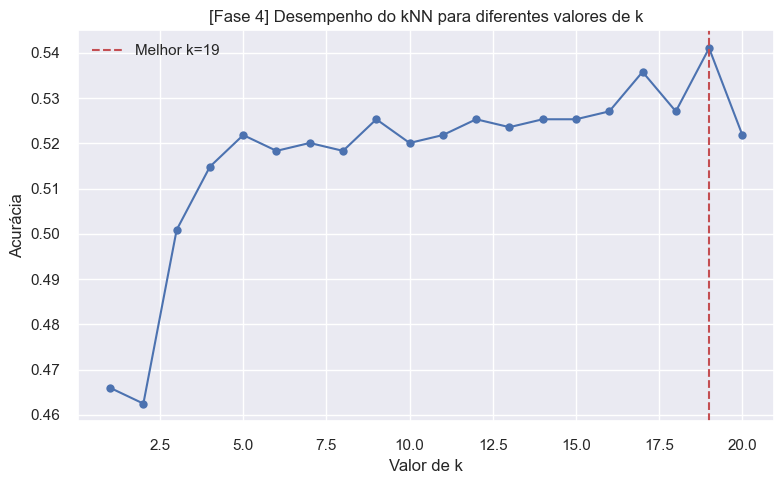

In [66]:
print("\n[Fase 4] Treinando classificador kNN...")

k_values = range(1, 21)
accuracies_knn = []

melhor_k = 1
melhor_acc_knn = 0.0
melhor_modelo_knn = None

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred_knn)
    accuracies_knn.append(acc)

    if acc > melhor_acc_knn:
        melhor_acc_knn = acc
        melhor_k = k
        melhor_modelo_knn = knn

print(f"[Fase 4] Melhor k para kNN: {melhor_k} com acurácia de {melhor_acc_knn:.4f}")

# Curva desempenho x k
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies_knn, marker='o')
plt.title('[Fase 4] Desempenho do kNN para diferentes valores de k')
plt.xlabel('Valor de k')
plt.ylabel('Acurácia')
plt.grid(True)
plt.axvline(x=melhor_k, color='r', linestyle='--', label=f'Melhor k={melhor_k}')
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
print("\n[Fase 4] Treinando classificador SVM...")

kernels = ['linear', 'rbf']
modelos_svm = {}
resultados_svm = {}

for kernel in kernels:
    print(f"  - Treinando SVM com kernel '{kernel}'...")
    svm = SVC(kernel=kernel, random_state=42)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    acc_svm = accuracy_score(y_test, y_pred_svm)

    modelos_svm[kernel] = svm
    resultados_svm[kernel] = {
        'accuracy': acc_svm,
        'predictions': y_pred_svm
    }

    print(f"    Acurácia SVM ({kernel}): {acc_svm:.4f}")

melhor_kernel = max(resultados_svm, key=lambda k: resultados_svm[k]['accuracy'])
melhor_acc_svm = resultados_svm[melhor_kernel]['accuracy']
melhor_modelo_svm = modelos_svm[melhor_kernel]

print(f"\n[Fase 4] Melhor kernel para SVM: '{melhor_kernel}' com acurácia de {melhor_acc_svm:.4f}")

print("\n[Fase 4] Comparação final:")
print(f"  - kNN (k={melhor_k}):    Acurácia = {melhor_acc_knn:.4f}")
print(f"  - SVM ({melhor_kernel}): Acurácia = {melhor_acc_svm:.4f}")

if melhor_acc_knn > melhor_acc_svm:
    print("  -> Classificador vencedor: kNN")
    classificador_final = melhor_modelo_knn
    y_pred_final = melhor_modelo_knn.predict(X_test)
    tipo_classificador = "kNN"
else:
    print("  -> Classificador vencedor: SVM")
    classificador_final = melhor_modelo_svm
    y_pred_final = resultados_svm[melhor_kernel]['predictions']
    tipo_classificador = "SVM"

print(f"\n[Fase 4] Classificação concluída. Usando {tipo_classificador} na Fase 5.")


[Fase 4] Treinando classificador SVM...
  - Treinando SVM com kernel 'linear'...
    Acurácia SVM (linear): 0.2740
  - Treinando SVM com kernel 'rbf'...
    Acurácia SVM (rbf): 0.4572

[Fase 4] Melhor kernel para SVM: 'rbf' com acurácia de 0.4572

[Fase 4] Comparação final:
  - kNN (k=19):    Acurácia = 0.5410
  - SVM (rbf): Acurácia = 0.4572
  -> Classificador vencedor: kNN

[Fase 4] Classificação concluída. Usando kNN na Fase 5.



[Fase 5] Gerando matriz de confusão...


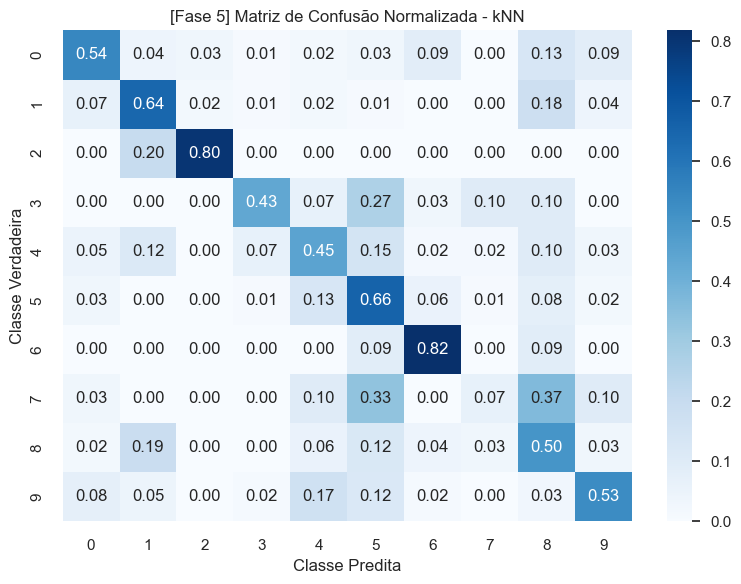


[Fase 5] Métricas detalhadas de classificação:


,precision,recall,f1-score,support
0,0.710145,0.544444,0.616352,90.000000
1,0.644444,0.644444,0.644444,90.000000
2,0.444444,0.800000,0.571429,5.000000
3,0.619048,0.433333,0.509804,30.000000
4,0.421875,0.450000,0.435484,60.000000
5,0.531532,0.655556,0.587065,90.000000
6,0.473684,0.818182,0.600000,22.000000
7,0.200000,0.066667,0.100000,30.000000
8,0.432692,0.500000,0.463918,90.000000
9,0.614035,0.530303,0.569106,66.000000



[Fase 5] Acurácia final do modelo (kNN): 0.5410


In [68]:
print("\n[Fase 5] Gerando matriz de confusão...")

if len(set(y_test)) == 0:
    print("Erro: Não há classes suficientes em y_test para gerar matriz de confusão.")
else:
    cm = confusion_matrix(y_test, y_pred_final)

    plt.figure(figsize=(8, 6))
    try:
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_norm,
                    annot=True,
                    fmt='.2f',
                    cmap='Blues',
                    xticklabels=sorted(set(y_test)),
                    yticklabels=sorted(set(y_test)))
        plt.title(f'[Fase 5] Matriz de Confusão Normalizada - {tipo_classificador}')
    except Exception as e:
        print(f"Aviso: não foi possível normalizar a matriz de confusão: {e}")
        sns.heatmap(cm,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    xticklabels=sorted(set(y_test)),
                    yticklabels=sorted(set(y_test)))
        plt.title(f'[Fase 5] Matriz de Confusão (não normalizada) - {tipo_classificador}')

    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Verdadeira')
    plt.tight_layout()
    plt.show()

print("\n[Fase 5] Métricas detalhadas de classificação:")

if len(set(y_test)) < 2:
    print("Aviso: Menos de 2 classes em y_test. Métricas não podem ser calculadas adequadamente.")
else:
    try:
        report = classification_report(
            y_test, y_pred_final, output_dict=True, zero_division=0
        )
        report_df = pd.DataFrame(report).transpose()
        display(report_df)

        acuracia_final = accuracy_score(y_test, y_pred_final)
        print(f"\n[Fase 5] Acurácia final do modelo ({tipo_classificador}): {acuracia_final:.4f}")
    except Exception as e:
        print(f"Erro ao calcular métricas: {e}")

In [70]:
print("\n[Fase 5] Análise de erros de classificação:")

y_test_array = np.array(y_test)
y_pred_array = np.array(y_pred_final)

erros_indices = np.where(y_test_array != y_pred_array)[0]
print(f"  - Total de erros: {len(erros_indices)} de {len(y_test_array)} amostras de teste.")

if len(erros_indices) > 0:
    print("  - Exemplos de erros (verdadeira -> predita):")
    for i, idx in enumerate(erros_indices[:10]):
        verdadeira = y_test_array[idx]
        predita = y_pred_array[idx]
        print(f"    {i+1}. Classe {verdadeira} foi classificada como {predita}.")

    pares_erros = [(y_test_array[idx], y_pred_array[idx]) for idx in erros_indices]
    contagem_erros = Counter(pares_erros)
    print("\n  - Pares de classes mais confundidos (verdadeira -> predita):")
    for par, count in contagem_erros.most_common(5):
        print(f"    Classe {par[0]} -> Classe {par[1]}: {count} vez(es)")
else:
    print("  - Nenhum erro de classificação foi encontrado!")


[Fase 5] Análise de erros de classificação:
  - Total de erros: 263 de 573 amostras de teste.
  - Exemplos de erros (verdadeira -> predita):
    1. Classe 8 foi classificada como 4.
    2. Classe 4 foi classificada como 7.
    3. Classe 1 foi classificada como 8.
    4. Classe 3 foi classificada como 7.
    5. Classe 8 foi classificada como 4.
    6. Classe 9 foi classificada como 1.
    7. Classe 9 foi classificada como 0.
    8. Classe 5 foi classificada como 4.
    9. Classe 3 foi classificada como 5.
    10. Classe 5 foi classificada como 0.

  - Pares de classes mais confundidos (verdadeira -> predita):
    Classe 8 -> Classe 1: 17 vez(es)
    Classe 1 -> Classe 8: 16 vez(es)
    Classe 5 -> Classe 4: 12 vez(es)
    Classe 0 -> Classe 8: 12 vez(es)
    Classe 8 -> Classe 5: 11 vez(es)
